In [0]:
import os
os.chdir("/content/drive/My Drive/Project_3/seq2sql")

In [2]:
!ls

data			       model.py      temp.py   wiki_sql.py
data-20200306T075156Z-001.zip  __pycache__   train.py
extract_data.py		       saved_models  utils.py


In [0]:
!pip install pytorch-pretrained-bert

In [5]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


100%|██████████| 231508/231508 [00:00<00:00, 1170324.75B/s]


In [0]:
import torch
import torch.nn as nn
from utils import get_next_decoder


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Encoder(nn.Module):

    def __init__(self, emb_dim, hidden_size, decoder_hidden_size, vocab_size):
        """
        Args:
            emb_dim (int): Embedding size
            hidden_size (int): Encoder hidden size
            decoder_hidden_size (int): Decoder hidden size
            vocab_size (int): Size of vocab
        """
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_size, bidirectional=True, dropout=0.2)

        self.fc = nn.Linear(hidden_size * 2, decoder_hidden_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        """
        Args:
            x(tensor): Input sentence of size (src len, batch size)
        Returns: Encoder output (src len, batch size, hidden * 2) and hidden (batch size, decoder_hidden_size)
        """
        # print("x device1", x.device)
        # x = x.long().cuda()
        # print("x device2", x.device)
        x = self.dropout(self.embedding(x.long().cpu()))                                                                      # (src len, batch size, emb_dim)
        x, h = self.gru(x)
        h = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)                                                                # concat last forward and backward cell's outputs
        h = torch.tanh(self.fc(h))
        return x, h


class Decoder(nn.Module):

    def __init__(self, emb_dim, vocab_size, hidden_size, encoder_hidden_size, decoder_vocab_dict, global_dict):
        """
        Args:
            emb_dim (int): Embedding size
            vocab_size (int): Size of vocab
            hidden_size (int): Decoder hidden size
            encoder_hidden_size (int): Encoder hidden size
            decoder_vocab_dict (dict): Dictionary of decoder vocab
            global_dict (dict): Dictionary of full vocab
        """
        super(Decoder, self).__init__()
        output_dim = len(decoder_vocab_dict.keys())
        self.hidden_size = hidden_size
        self.decoder_vocab_dict = decoder_vocab_dict
        self.global_dict = global_dict

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.gru = nn.GRU((encoder_hidden_size * 2) + emb_dim, hidden_size, dropout=0.2)

        self.attn_fc = nn.Linear((encoder_hidden_size * 2) + hidden_size, 1)

        self.fc = nn.Linear((encoder_hidden_size * 2) + hidden_size + emb_dim, output_dim)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sql, idx, h, encoder_outputs, decoder_dict, current_decoder, predictions=None, targets=None,
                decoders=None, print_output=False):
        """
        Args:
            sql (tensor): Tensor of all sql (batch_size, src len)
            idx (int): Index of current input
            h (tensor): (batch_size, hidden_size)
            encoder_outputs (tensor): (src len, batch size, enc_hid_dim * 2)
            decoder_dict (dict): Dictionary of decoder models
            current_decoder (str): Current decoder name
            predictions (list): List of all predictions
            targets (list): List of targets in local dictionary mappings
            decoders (list): List of decoders for each prediction
            print_output (bool): If true, give output on screen
        Returns: Decoder output (batch size, vocab) and hidden (1, batch size, hidden)
        """
        if decoders is None:
            decoders, targets, predictions = [], [], []
        if print_output:
            print('\n\nCurrent Decoder: {}\ni = {}'.format(current_decoder, idx))
        if current_decoder == 'RootDecoder':
            next_decoders = get_next_decoder(current_decoder, decoder_dict)

            for next_decoder, decoder_name in next_decoders:
                idx += 1
                if decoder_name == 'AggregatorDecoder':
                    # predictions.append(torch.tensor([26173]))                                                         # select
                    # targets.append(torch.tensor([26173]))
                    idx += 1
                elif decoder_name == 'TableDecoder':
                    # predictions.append(torch.tensor([19884]))                                                         # from
                    # targets.append(torch.tensor([19884]))
                    idx += 1
                predictions, targets, decoders, idx = next_decoder(sql, idx, h, encoder_outputs, decoder_dict,
                                                                   decoder_name, predictions, targets, decoders,
                                                                   print_output)

                if idx == sql.size(1):
                    return predictions, targets, decoders

            if idx != sql.size(1):
                predictions.extend([predictions[-1] for x in range(sql.size(1) - idx)])                                 # appending padding of 1s to punish decoder for not predicting the remaining words
                targets.extend([targets[-1] for x in range(sql.size(1) - idx)])                                         # appending padding of 0s
                decoders.extend([decoders[-1] for x in range(sql.size(1) - idx)])

            return predictions, targets, decoders

        if idx == sql.size(1):
            return predictions, targets, decoders, idx
        x = sql[:, idx]

        # Attention
        src_len = encoder_outputs.shape[0]
        h_rep = h.unsqueeze(1).repeat(1, src_len, 1)                                                                    # (batch size, src len, dec hid dim) 5, 100, 20
        encoder_outputs_rearranged = encoder_outputs.permute(1, 0, 2)                                                   # (batch size, src len, enc_hid_dim * 2) 5, 100, 100
        weights = torch.tanh(self.attn_fc(torch.cat((h_rep, encoder_outputs_rearranged), dim=2)))                       # (batch size, src len, 1)

        embedded = self.embedding(x.long()).squeeze(1)                                                                  # (batch_size, emb_dim)
        embedded = self.dropout(embedded)

        weighted = torch.bmm(encoder_outputs_rearranged.permute(0, 2, 1), weights).squeeze(2)                           # (batch size, enc_hid_dim * 2)
        x = torch.cat((embedded, weighted), dim=1)                                                                      # (batch size, emb_dim + enc_hid_dim*2)
        x, h = self.gru(x.unsqueeze(0), h.unsqueeze(0))                                                                 # src size = 1

        # assert (x == h).all()

        x = self.softmax(self.fc(torch.cat((x.squeeze(0), weighted, embedded), dim=1)))                                 # (batch size, output_dim)
        # x = x.argmax(1)                                                                                               # (batch_size, 1)
        # for n, index in enumerate(x):                                                                                   # Decoder vocab to word mapping
        #     print(self.decoder_vocab_dict[index.item()])
        #     x[n] = self.global_dict[self.decoder_vocab_dict[index.item()]]
        if x.argmax(1) != x.size(1) - 1 or current_decoder not in ['KeywordDecoder', 'OperatorDecoder', 'AndOrDecoder',
                                                                   'AggregatorDecoder']:
            if print_output:
                print('Predicted: {}\nTarget: {}'.format(list(self.decoder_vocab_dict.keys())[x.argmax(1).item()],
                                                               self.global_dict[int(sql[:, idx].item())]))
            predictions.append(x)
            try:
                targets.append(torch.tensor([self.decoder_vocab_dict[self.global_dict[sql[:, idx].item()]]]))
            except KeyError:
                targets.append(torch.tensor([x.size(1) - 1]))
            decoders.append(current_decoder)

            next_decoders = get_next_decoder(current_decoder, decoder_dict)

            if self.global_dict[int(sql[:, idx].item())] not in self.decoder_vocab_dict.keys():                         # Wrong decoder
                idx -= 1
                return predictions, targets, decoders, idx
            for next_decoder, decoder_name in next_decoders:
                idx = idx + 1
                predictions, targets, decoders, idx = next_decoder(sql, idx, h.squeeze(0), encoder_outputs,
                                                                   decoder_dict, decoder_name, predictions,
                                                                   targets, decoders, print_output)
        else:                                                                                                           # None
            if self.global_dict[int(sql[:, idx].item())] in self.decoder_vocab_dict.keys():                             # Wrongly predicted None
                predictions.append(x)
                try:
                    targets.append(torch.tensor([self.decoder_vocab_dict[self.global_dict[sql[:, idx].item()]]]))
                except KeyError:
                    targets.append(torch.tensor([x.size(1) - 2]))
                decoders.append(current_decoder)
            else:
                idx -= 1

        return predictions, targets, decoders, idx


# if __name__ == "__main__":
#     encoder = Encoder(3, 50, 40, 1000)
#     inp = torch.randint(0, 1000, (100, 5))
#     output = encoder(inp)
#     print(output[0].size(), output[1].size())
#
#     decoder = Decoder(3, 1000, 40, 50)
#     print(decoder(torch.randint(0, 1000, (5, 1)), output[1], output[0]))


  0%|          | 0/56355 [00:00<?, ?it/s]



Text: <s> tell me what the notes are for south australia </s>
SQL: <s> select notes from 1-1000181-1 where current_slogan = south_australia </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: min
Target: notes


Current Decoder: ColumnDecoder
i = 2
Predicted: registration_no.
Target: notes


Current Decoder: OperatorDecoder
i = 3
Predicted: <
Target: from


Current Decoder: TableDecoder
i = 4
Predicted: 1-17369472-2
Target: 1-1000181-1


Current Decoder: KeywordDecoder
i = 5


  0%|          | 2/7939 [00:00<06:40, 19.83it/s]



Text: <s> what is the winning song for the artist with a debut album " the winner " ? </s>
SQL: <s> select winning_song from 1-1646960-3 where debut_album = the_winner </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2


Current Decoder: ColumnDecoder
i = 2
Predicted: grand_final_dual_television_commentator
Target: winning_song


Current Decoder: OperatorDecoder
i = 3


Current Decoder: TableDecoder
i = 4
Predicted: 2-10826385-14
Target: 1-1646960-3


Current Decoder: KeywordDecoder
i = 5


Epoch: 0    total_cost =  115.3135757446289    validLoss = 124.0158576965332


  0%|          | 0/56355 [00:00<?, ?it/s]



Text: <s> tell me what the notes are for south australia </s>
SQL: <s> select notes from 1-1000181-1 where current_slogan = south_australia </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: min
Target: notes


Current Decoder: ColumnDecoder
i = 2
Predicted: registration_no.
Target: notes


Current Decoder: OperatorDecoder
i = 3


Current Decoder: TableDecoder
i = 4
Predicted: 2-1122914-2
Target: 1-1000181-1


Current Decoder: KeywordDecoder
i = 5


  0%|          | 2/7939 [00:00<08:42, 15.19it/s]



Text: <s> in what round was the draft pick from florida with an overall less than 166 ? </s>
SQL: <s> select avg round from 2-15198842-33 where college = florida and overall < florida </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: count
Target: avg


Current Decoder: ColumnDecoder
i = 3
Predicted: react
Target: round


Current Decoder: OperatorDecoder
i = 4
Predicted: <
Target: from


Current Decoder: TableDecoder
i = 5
Predicted: 2-1204658-9
Target: 2-15198842-33


Current Decoder: KeywordDecoder
i = 6


Epoch: 1    total_cost =  112.42851066589355    validLoss = 126.83207702636719


  0%|          | 0/56355 [00:00<?, ?it/s]



Text: <s> tell me what the notes are for south australia </s>
SQL: <s> select notes from 1-1000181-1 where current_slogan = south_australia </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: min
Target: notes


Current Decoder: ColumnDecoder
i = 2
Predicted: net_run_rate
Target: notes


Current Decoder: OperatorDecoder
i = 3
Predicted: <
Target: from


Current Decoder: TableDecoder
i = 4
Predicted: 1-17993994-5
Target: 1-1000181-1


Current Decoder: KeywordDecoder
i = 5


  0%|          | 2/7939 [00:00<07:47, 16.98it/s]



Text: <s> what years did bobby moore play ? </s>
SQL: <s> select nasl_years from 1-237757-9 where player = <none> </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: sum
Target: nasl_years


Current Decoder: ColumnDecoder
i = 2
Predicted: sri_lankan_moors
Target: nasl_years


Current Decoder: OperatorDecoder
i = 3


Current Decoder: TableDecoder
i = 4
Predicted: 1-17311797-11
Target: 1-237757-9


Current Decoder: KeywordDecoder
i = 5


Epoch: 2    total_cost =  152.34536933898926    validLoss = 123.40867805480957


  0%|          | 0/56355 [00:00<?, ?it/s]



Text: <s> tell me what the notes are for south australia </s>
SQL: <s> select notes from 1-1000181-1 where current_slogan = south_australia </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: sum
Target: notes


Current Decoder: ColumnDecoder
i = 2
Predicted: current_3_november_2013
Target: notes


Current Decoder: OperatorDecoder
i = 3


Current Decoder: TableDecoder
i = 4
Predicted: 2-1616581-1
Target: 1-1000181-1


Current Decoder: KeywordDecoder
i = 5
Predicted: where
Target: where


Current Decoder: ColumnDecoder
i = 6
Predicted: governor
Target: current_slogan


Current Decoder: OperatorDecoder
i = 7
Predicted: >
Target: =


Current Decoder: ConstantDecoder
i = 8
Predicted: 2-17651219-1
Target: south_australia


Current Decoder: AndOrDecoder
i = 9
Predicted: and
Target: </s>


  0%|          | 2/7939 [00:00<12:18, 10.74it/s]



Text: <s> what is the average when 2nd highest was <none> ? </s>
SQL: <s> select max average from 1-237757-10 where 2nd_highest = <none> </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: sum
Target: max


Current Decoder: ColumnDecoder
i = 3
Predicted: shigella
Target: average


Current Decoder: OperatorDecoder
i = 4
Predicted: <
Target: from


Current Decoder: TableDecoder
i = 5
Predicted: 2-11503671-1
Target: 1-237757-10


Current Decoder: KeywordDecoder
i = 6
Predicted: where
Target: where


Current Decoder: ColumnDecoder
i = 7
Predicted: foreign_nationality
Target: 2nd_highest


Current Decoder: OperatorDecoder
i = 8
Predicted: <
Target: =


Current Decoder: ConstantDecoder
i = 9
Predicted: the_netherlands
Target: <none>


Current Decoder: AndOrDecoder
i = 10
Predicted: and
Target: </s>


Epoch: 3    total_cost =  171.38968658447266    validLoss = 138.30385208129883


  0%|          | 0/56355 [00:00<?, ?it/s]



Text: <s> tell me what the notes are for south australia </s>
SQL: <s> select notes from 1-1000181-1 where current_slogan = south_australia </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: sum
Target: notes


Current Decoder: ColumnDecoder
i = 2
Predicted: registration_no.
Target: notes


Current Decoder: OperatorDecoder
i = 3
Predicted: <
Target: from


Current Decoder: TableDecoder
i = 4
Predicted: 1-17369472-2
Target: 1-1000181-1


Current Decoder: KeywordDecoder
i = 5


  0%|          | 2/7939 [00:00<08:00, 16.52it/s]



Text: <s> in womens doubles and mens <none> what years did <none> <none> or <none> <none> <none> <none> win ? </s>
SQL: <s> select womens_doubles from 1-12194021-1 where mens_singles = <none> and mixed_doubles = <none> </s>


Current Decoder: RootDecoder
i = 0


Current Decoder: AggregatorDecoder
i = 2
Predicted: avg
Target: womens_doubles


Current Decoder: ColumnDecoder
i = 2
Predicted: trekking_route
Target: womens_doubles


Current Decoder: OperatorDecoder
i = 3
Predicted: =
Target: from


Current Decoder: TableDecoder
i = 4
Predicted: 1-17030926-3
Target: 1-12194021-1


Current Decoder: KeywordDecoder
i = 5


Epoch: 4    total_cost =  149.5994110107422    validLoss = 154.22818565368652


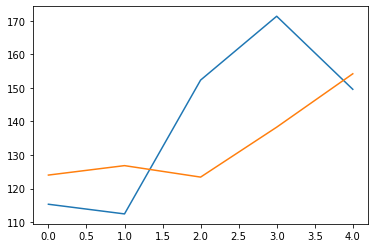

In [25]:
import torch
from torch import optim
import torch.nn as nn
from wiki_sql import WikiSQL
# from model import Encoder, Decoder
from torch.utils.data import DataLoader
from extract_data import load_pickle
import os
from tqdm import tqdm
from utils import get_decoder_vocab_dicts, save_models, zero_all_grads
from extract_data import load_pickle
import os
import matplotlib.pyplot as plt

root = 'data'
# questions_path = 'data/questions/'
# sql_queries_path = 'data/sql_queries/'
# word_idx_mappings_path = 'data/word_idx_mappings/'
# wiki_sql_path = 'data/WikiSQL_files/'
vocab_size = 1                                                                                                          # Size of vocab, set later
enc_hidden_size = 40                                                                                                    # Size of h from each LSTM cell encoder        2*enc > dec
dec_hidden_size = 30                                                                                                    # Should be even
num_layers = 1                                                                                                          # Number of LSTM cells stacked one above other. Not used
num_epochs = 10
learning_rate = 3e-5
sequence_length = 1                                                                                                     # One word per lstm cell (not used)
encoder_output_size = 0                                                                                                 # Size of encoding and size of decoder input
batch_size = 1
embed_dim = 50
# keyword_output_dim = 2                                                                                                  # [where, none]
# column_output_dim = 0                                                                                                   # no of col in vocab, set later
# table_output_dim = 0                                                                                                    # no of tables in vocab, set later
# operator_output_dim = 6                                                                                                 # {>, <, =, <=, >=, !=, none}
# aggregator_output_dim = 6                                                                                               # {max, min, count, sum, avg, none}
# # root_output_dim = 0                                                                                                   # no of tables in vocab, set later
# and_or_output_dim = 3                                                                                                   # {and, or, none}
# constant_output_dim = 0                                                                                                 # V + col. Set later


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if __name__ == "__main__":

    train_transformed_dataset = WikiSQL(text=os.path.join(root, 'train/train_questions_tokenized.pkl'),
                                        sql=os.path.join(root, 'train/train_sql_tokenized.pkl'),
                                        schema=os.path.join(root, 'train/', 'train_schema.pkl')
                                        )

    test_transformed_dataset = WikiSQL(text=os.path.join(root, 'test/test_questions_tokenized.pkl'),
                                        sql=os.path.join(root, 'test/test_sql_tokenized.pkl'),
                                       schema=os.path.join(root, 'test/test_schema.pkl')
                                       )

    valid_transformed_dataset = WikiSQL(text=os.path.join(root, 'valid/valid_questions_tokenized.pkl'),
                                        sql=os.path.join(root, 'valid/valid_sql_tokenized.pkl'),
                                        schema=os.path.join(root, 'valid/valid_schema.pkl')
                                        )

    word2idx = load_pickle(os.path.join(root, 'word_idx_mappings/word2idx.pkl'))
    idx2word = load_pickle(os.path.join(root, 'word_idx_mappings/idx2word.pkl'))
    col_dict = load_pickle(os.path.join(root, 'word_idx_mappings/column_mappings1.pkl'))
    table_dict = load_pickle(os.path.join(root, 'word_idx_mappings/table_mappings1.pkl'))
    vocab_size = len(word2idx.keys())

    vocab_dicts = get_decoder_vocab_dicts(word2idx, table_dict, col_dict)

    train_loader = DataLoader(train_transformed_dataset, batch_size=batch_size, shuffle=False,
                              collate_fn=train_transformed_dataset.collate)
    test_loader = DataLoader(test_transformed_dataset, batch_size=batch_size, shuffle=True,
                             collate_fn=test_transformed_dataset.collate)
    valid_loader = DataLoader(valid_transformed_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=valid_transformed_dataset.collate)
    loss = nn.NLLLoss()

    # emb_dim, hidden_size, decoder_hidden_size, vocab_size
    encoder_dict = {
        'QuestionEncoder': Encoder(embed_dim, enc_hidden_size, int(dec_hidden_size / 2), vocab_size),
        'SchemaEncoder': Encoder(embed_dim, enc_hidden_size, int(dec_hidden_size / 2), vocab_size)
    }

    # emb_dim, vocab_size, hidden_size, encoder_hidden_size, output_dim, decoder_vocab_dict, global_dict
    decoder_dict = {
        'KeywordDecoder': Decoder(embed_dim, vocab_size, dec_hidden_size, enc_hidden_size, vocab_dicts['KeywordDecoder'], idx2word).to(device),
        'ColumnDecoder': Decoder(embed_dim, vocab_size, dec_hidden_size, enc_hidden_size, vocab_dicts['ColumnDecoder'], idx2word).to(device),
        'TableDecoder': Decoder(embed_dim, vocab_size, dec_hidden_size, enc_hidden_size, vocab_dicts['TableDecoder'], idx2word).to(device),
        'OperatorDecoder': Decoder(embed_dim, vocab_size, dec_hidden_size, enc_hidden_size, vocab_dicts['OperatorDecoder'], idx2word).to(device),
        'AggregatorDecoder': Decoder(embed_dim, vocab_size, dec_hidden_size, enc_hidden_size, vocab_dicts['AggregatorDecoder'], idx2word).to(device),
        'RootDecoder': Decoder(embed_dim, vocab_size, dec_hidden_size, enc_hidden_size, vocab_dicts['RootDecoder'], idx2word).to(device),
        'AndOrDecoder': Decoder(embed_dim, vocab_size, dec_hidden_size, enc_hidden_size, vocab_dicts['AndOrDecoder'], idx2word).to(device),
        'ConstantDecoder': Decoder(embed_dim, vocab_size, dec_hidden_size, enc_hidden_size, vocab_dicts['ConstantDecoder'], idx2word).to(device)
    }

    encoder_optimizer, decoder_optimizer = {}, {}
    for name, encoder in encoder_dict.items():
        encoder_optimizer[name] = optim.Adam(encoder.parameters(), lr=learning_rate)
    for name, decoder in decoder_dict.items():
        decoder_optimizer[name] = optim.Adam(decoder.parameters(), lr=learning_rate)

    total_step = len(train_loader)
    losses = []
    for epoch in range(num_epochs):
        total_cost = 0
        for n, sample in enumerate(tqdm(train_loader)):

            text = sample[0].to(device)
            sql = sample[1].to(device)
            schema = sample[2].to(device)

            question_enc_outputs, question_enc_hidden = encoder_dict['QuestionEncoder'](text.t())
            question_enc_outputs = question_enc_outputs.to(device)
            question_enc_hidden = question_enc_hidden.to(device)
            schema_enc_outputs, schema_enc_hidden = encoder_dict['SchemaEncoder'](schema.t())
            schema_enc_outputs = schema_enc_outputs.to(device)
            schema_enc_hidden = schema_enc_hidden.to(device)

            hidden = torch.cat((question_enc_hidden, schema_enc_hidden), dim=-1)
            enc_outputs = torch.cat((question_enc_outputs, schema_enc_outputs), dim=0)

            if n in [0, int(len(train_loader) / 3), 2 * int(len(train_loader) / 3)]:
                print_outputs = True
                print('\n\nText: {}\nSQL: {}'.format(' '.join(list(map(lambda i: idx2word[i.item()], text[0]))),
                                                     ' '.join(list(map(lambda i: idx2word[i.item()], sql[0])))))
            else:
                print_outputs = False

            # sql, idx, h, encoder_outputs, decoder_dict, current_decoder, predictions, print_outputs
            outputs, targets, decoders = decoder_dict['RootDecoder'](sql, 0, hidden, enc_outputs, decoder_dict, 'RootDecoder', print_output=print_outputs)
            # print(sql, targets, outputs)
            # where_pos = list(map(len, outputs))

            # cost = loss(outputs[0], targets[0])
            epoch_loss = 0
            for output, target, decoder_name in zip(outputs, targets, decoders):
                target = target.cuda()
                zero_all_grads(encoder_optimizer, decoder_optimizer)
                cost = loss(output, target)
                cost.backward(retain_graph=True)
                decoder_optimizer[decoder_name].step()
                epoch_loss += cost

            zero_all_grads(encoder_optimizer, decoder_optimizer)                                                        # Zeros grads for all encoders
            epoch_loss.backward()                                                                                       # Backward for encoder loss
            for encoder in encoder_optimizer.values():
                encoder.step()

            total_cost += epoch_loss.double()

            # if n == 3:
            #     break

        valid_loss = 0
        with torch.no_grad():
            for n, sample in enumerate(tqdm(valid_loader)):

                text = sample[0].to(device)
                sql = sample[1].to(device)
                schema = sample[2].to(device)

                question_enc_outputs, question_enc_hidden = encoder_dict['QuestionEncoder'](text.t())
                question_enc_outputs = question_enc_outputs.to(device)
                question_enc_hidden = question_enc_hidden.to(device)
                schema_enc_outputs, schema_enc_hidden = encoder_dict['SchemaEncoder'](schema.t())
                schema_enc_outputs = schema_enc_outputs.to(device)
                schema_enc_hidden = schema_enc_hidden.to(device)

                hidden = torch.cat((question_enc_hidden, schema_enc_hidden), dim=-1)
                enc_outputs = torch.cat((question_enc_outputs, schema_enc_outputs), dim=0)

                if n in [0, int(len(train_loader) / 3), 2 * int(len(train_loader) / 3)]:
                    print_outputs = True
                    print('\n\nText: {}\nSQL: {}'.format(' '.join(list(map(lambda i: idx2word[i.item()], text[0]))),
                                                         ' '.join(list(map(lambda i: idx2word[i.item()], sql[0])))))
                else:
                    print_outputs = False

                # sql, idx, h, encoder_outputs, decoder_dict, current_decoder, predictions, print_outputs
                outputs, targets, decoders = decoder_dict['RootDecoder'](sql, 0, hidden, enc_outputs, decoder_dict, 'RootDecoder', print_output=print_outputs)

                # print(sql, targets, outputs)
                # where_pos = list(map(len, outputs))

                # cost = loss(outputs[0], targets[0])
                epoch_loss = 0
                for output, target, decoder_name in zip(outputs, targets, decoders):
                    target = target.cuda()
                    zero_all_grads(encoder_optimizer, decoder_optimizer)
                    epoch_loss += loss(output, target)

                valid_loss += epoch_loss.double()

                if n == 3:
                    break

            print('Epoch: {}    total_cost =  {}    validLoss = {}'.format(epoch, total_cost, valid_loss))
        save_models(encoder_dict, decoder_dict, epoch)

        losses.append([total_cost, valid_loss])

        if epoch == 4:
            break

    plt.plot(losses)
    plt.show()
